# TMAA – Projeto #1
### Análise de Componentes Principais (PCA) para a Compressão de Imagens RGB

### 👥 Grupo XXX
- **Pedro Fonte Santa**, nº 105306  
- **XXX**, nº XXX  

---

📅 **Data de entrega:** 07 de Novembro

📊 **Objetivo:** 
O objetivo deste projeto é usar análise de componentes principais (PCA) para realizar e estudar a compressão de imagens. 

---

### 🗂️ Dataset: eye_image.jpg

---

### (a) Importar e preparar a imagem

Carregar a imagem `eye_image.jpg` em tons de cinzento e redimensioná-la para 16×16. A matriz resultante vai chamar-se **X**.


In [2]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

Dimensão original: (734, 712)
Dimensão de X: (16, 16)


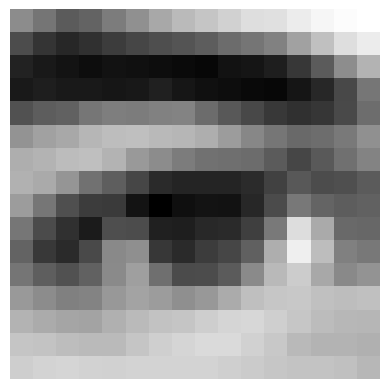

In [ ]:
img = cv2.imread('eye_image.jpg', cv2.IMREAD_GRAYSCALE) # carregar a imagem em tons de cinzento

print("Dimensão original:", img.shape)

img16 = cv2.resize(img, (16, 16), interpolation=cv2.INTER_LINEAR) # redimensionar para 16 x 16

X = np.array(img16, dtype=float)
print("Dimensão de X:", X.shape)


plt.imshow(img16, cmap='gray')
plt.axis('off')
plt.show()

### (b) Centrar os dados (remover a média de cada linha)

Tratar cada linha de **X** como um vetor em $ \mathbb{R}^{16} $.  
Calculamos o **vetor média** $ \boldsymbol{\mu} $ (média de todas as linhas de X) e subtraímos esse vetor a cada linha.  
O resultado é uma nova matriz **Y**, cujas linhas estão **centradas na origem**, exatamente o que se faz antes da decomposição SVD / PCA.


In [ ]:
mu = np.mean(X, axis=0) # vetor média (média das linhas, ou seja, dos 16 vetores em R16)

Y = X - mu
# verificar as dimensões e mostrar resultados
print("Dimensão de μ:", mu.shape)
print("Dimensão de Y:", Y.shape)

# mostrar o vetor média e uma parte da matriz centrada
print("\nVetor média μ:")
print(mu)

print("\nPrimeiras 3 linhas da matriz centrada Y:")
print(Y[:3])

Dimensão de μ: (16,)
Dimensão de Y: (16, 16)

Vetor média μ:
[166.625  158.6875 151.875  152.5    161.0625 161.1875 153.125  150.9375
 152.     153.8125 158.3125 166.6875 177.75   175.     175.     182.625 ]

Primeiras 3 linhas da matriz centrada Y:
[[  6.375   -0.6875 -10.875   -6.5      1.9375  14.8125  38.875   53.0625
   59.      65.1875  69.6875  62.3125  59.25    69.      73.      67.375 ]
 [-35.625  -43.6875 -45.875  -40.5    -41.0625 -34.1875 -21.125  -14.9375
  -10.      -1.8125  -0.3125  -0.6875   9.25    33.      53.      54.375 ]
 [-63.625  -61.6875 -58.875  -63.5    -69.0625 -70.1875 -64.125  -63.9375
  -67.     -61.8125 -64.3125 -66.6875 -60.75   -34.      -1.      16.375 ]]


### (c) Decomposição em Valores Singulares (SVD) e construção das matrizes de descodificação

Vamos:
1. aplicar a SVD à matriz centrada $Y$, obtendo $Y = U \Sigma V^T$;
2. usar as **primeiras colunas de** $V$ (i.e. de `Vt.T`) para construir as **matrizes de descodificação** $D_i$, para $i = 2, 5, 10$.

Como em PCA as direções principais são dadas pelos **vetores singulares direitos** (colunas de $V$),  
a matriz de descodificação com $i$ componentes principais é simplesmente:

$$
D_i = V_{[:,\,0:i]}
$$

Cada $D_i$ terá dimensão $16 \times i$ porque temos 16 features (a imagem foi reduzida para $16\times16$).


In [6]:
U, S, Vt = np.linalg.svd(Y, full_matrices=False) # SVD da matriz centrada Y

print("Dimensão de U:", U.shape)
print("Dimensão de S:", S.shape)   # vetor de 16 entradas
print("Dimensão de Vᵀ:", Vt.shape)

componentes = [2, 5, 10] # construir matrizes de descodificação D_i para i = 2, 5, 10
D = {}   

V = Vt.T   # V é 16x16: colunas = componentes principais

for i in componentes:
    Di = V[:, :i]     # ficar só com as primeiras i colunas
    D[i] = Di
    print(f"\nMatriz de descodificação D_{i} -> shape {Di.shape}")


print("\nD_2 =\n", D[2])

Dimensão de U: (16, 16)
Dimensão de S: (16,)
Dimensão de Vᵀ: (16, 16)

Matriz de descodificação D_2 -> shape (16, 2)

Matriz de descodificação D_5 -> shape (16, 5)

Matriz de descodificação D_10 -> shape (16, 10)

D_2 =
 [[-0.18117431  0.15158831]
 [-0.20358163  0.27615418]
 [-0.22102199  0.3413339 ]
 [-0.23832525  0.31072731]
 [-0.24029557  0.16550408]
 [-0.27346273  0.07726116]
 [-0.30985579  0.11638805]
 [-0.31755862  0.10487238]
 [-0.32641317  0.03274367]
 [-0.32810435 -0.04673289]
 [-0.31437472 -0.14839953]
 [-0.26460735 -0.28704538]
 [-0.18700003 -0.44993384]
 [-0.18147451 -0.40287286]
 [-0.16182899 -0.3069395 ]
 [-0.1164717  -0.25132018]]


### (d) Codificação com $i$ componentes principais

Vamos **codificar** (ou projetar) os dados centrados $Y$ no subespaço gerado pelas primeiras $i$ componentes principais.  

Isto faz-se multiplicando a transposta de $Y$ à esquerda pela matriz de codificação $D_i^T$, ou seja:

$$
Z_i = D_i^T Y^T
$$

O resultado $Z_i$ representa a **versão comprimida** da imagem, expressa em apenas $i$ componentes principais (em vez das 16 originais).  
Neste caso, com $i = 2$.

In [7]:
i = 2

# matriz de codificação (transposta da descodificação)
Di = D[i]
Di_T = Di.T

# codificação: projeção dos dados centrados Y no subespaço das i componentes
Z_i = Di_T @ Y.T   # resultado é i x 16

print(f"Dimensão de Z_{i}:", Z_i.shape)
print(f"\nZ_{i} (primeiras linhas):\n", Z_i[:, :5])

Dimensão de Z_2: (2, 16)

Z_2 (primeiras linhas):
 [[-152.77993651   47.15572962  223.99431557  241.28868397   60.15624963]
 [-116.53946263 -106.55960961  -30.92497541   30.53054324   88.01171785]]
